In [78]:
# Standard library imports
from datetime import datetime
import os

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Visualize loop progress
import xlwings as xw # dynamic Excel interaction
from lightweight_charts import Chart
import mplfinance as mpf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Set pandas display options for better data frame visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Segreti
from dotenv import load_dotenv
load_dotenv()

# API
import requests
import json

| Gap-Up Screener |
|--|
TradingView Data (import)

In [79]:
# today's date string for file naming automation
today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
# today_date_str = '_2024-03-06.csv'

print(today_date_str)

_2024-03-20.csv


In [80]:
# concat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"
# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

1094 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower"
0,MSFT,Microsoft Corporation,NASDAQ,3141514078603.6235,USD,422.7900,USD,420.88,USD,0.65,USD,0.154244,-0.125768,7318745625.92,4848870,44792762.0,36714,21644331.3,21422667.26666667,24527694.64444445,0.539462,1.526198,1.671906,422.126433,38.23835322,Technology Services,0.4769729,0.9321239,1.0291758,0.8906199,0.008975,1.096426,0.220253,0.300660,0.374065,0.218812,0.49215017,0.20727121,0.39333971,0.56689086,427.82,USD,427.82,USD,427.82,USD,427.82,USD,427.82000,USD,422.9293,USD,422.9293,USD,422.9293,USD,422.9293,USD,422.9293,USD,422.9293,USD,422.9293,USD,422.9293,USD,427.82,USD,958891.40271493,USD,422.73844,422.640900,422.49202,422.427523,422.837927,422.501860,422.165793,423.260395,422.056360,420.852325
1,NVDA,NVIDIA Corporation,NASDAQ,2211001451695.214,USD,884.4006,USD,890.22,USD,3.97,USD,0.444082,-0.420591,2400415000,20574435,154689155.0,543882,65235987.7,58634920.59999999,48561411.71111124,2.478945,4.433728,4.898136,890.243533,74.09212081,Electronic Technology,0.56425041,1.8244131,2.3419523,1.7245569,0.001510,1.271847,0.304976,0.385623,0.442288,0.251271,0.68135528,0.29816475,0.58361734,0.86663239,974.00,USD,974.00,USD,974.00,USD,974.00,USD,974.00000,USD,884.9000,USD,884.9000,USD,886.4500,USD,890.8600,USD,890.8600,USD,904.1000,USD,904.1000,USD,924.0500,USD,974.00,USD,2058175.67567568,USD,883.98200,883.732875,884.68752,886.645900,886.137227,884.485075,882.832923,891.020276,887.164660,883.309044
2,GOOG,Alphabet Inc.,NASDAQ,1842739645137.6536,USD,148.7002,USD,147.80,USD,0.91,USD,0.615197,-0.081125,5274001645,5954520,71379576.0,95121,26033003.09999997,24696893.50000004,22846069.04444446,1.147097,1.991157,2.109368,148.749033,25.61500034,Technology Services,0.4674221,0.97195053,1.1586931,1.0489115,0.041168,0.446769,0.121263,0.297177,0.471703,0.161222,0.46747951,0.21453809,0.62393874,0.79559766,152.93,USD,155.20,USD,155.20,USD,155.20,USD,155.20000,USD,148.7600,USD,148.7600,USD,148.7850,USD,148.8000,USD,148.8000,USD,149.6169,USD,149.6169,USD,152.9300,USD,152.93,USD,1683033.61059057,USD,148.68100,148.630625,148.66628,148.619592,148.787357,148.642260,148.497163,148.866605,148.528485,148.190365
3,GOOGL,Alphabet Inc.,NASDAQ,1842733340169.4243,USD,147.

In [81]:
def categorize_market_cap(df):
    # convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    # define conditions for market cap categories
    conditions = [
        # Titans
        (df['Market capitalization'] >= 200000000000),  # 200 billion and above
        #Large Cap
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),  # 10 billion to 200 billion
        # Midlers
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),  # 2 billion to 10 billion
        # Small Cap
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000),  # 300 million to 2 billion
        # Micro Cap
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),  # 300 million and below (excluding 50 million and below)
        # Shrimp
        (df['Market capitalization'] <= 50000000)  # 50 million and below
    ]
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    # use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df


In [82]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,MSFT,Microsoft Corporation,NASDAQ,3.141514e+12,USD,422.7900,USD,420.88,USD,0.65,USD,0.154244,-0.125768,7318745625.92,4848870,44792762.0,36714,21644331.3,21422667.26666667,24527694.64444445,0.539462,1.526198,1.671906,422.126433,38.23835322,Technology Services,0.4769729,0.9321239,1.0291758,0.8906199,0.008975,1.096426,0.220253,0.300660,0.374065,0.218812,0.49215017,0.20727121,0.39333971,0.56689086,427.82,USD,427.82,USD,427.82,USD,427.82,USD,427.82000,USD,422.9293,USD,422.9293,USD,422.9293,USD,422.9293,USD,422.9293,USD,422.9293,USD,422.9293,USD,422.9293,USD,427.82,USD,958891.40271493,USD,422.73844,422.640900,422.49202,422.427523,422.837927,422.501860,422.165793,423.260395,422.056360,420.852325,Titans
1,NVDA,NVIDIA Corporation,NASDAQ,2.211001e+12,USD,884.4006,USD,890.22,USD,3.97,USD,0.444082,-0.420591,2400415000,20574435,154689155.0,543882,65235987.7,58634920.59999999,48561411.71111124,2.478945,4.433728,4.898136,890.243533,74.09212081,Electronic Technology,0.56425041,1.8244131,2.3419523,1.7245569,0.001510,1.271847,0.304976,0.385623,0.442288,0.251271,0.68135528,0.29816475,0.58361734,0.86663239,974.00,USD,974.00,USD,974.00,USD,974.00,USD,974.00000,USD,884.9000,USD,884.9000,USD,886.4500,USD,890.8600,USD,890.8600,USD,904.1000,USD,904.1000,USD,924.0500,USD,974.00,USD,2058175.67567568,USD,883.98200,883.732875,884.68752,886.645900,886.137227,884.485075,882.832923,891.020276,887.164660,883.309044,Titans
2,GOOG,Alphabet Inc.,NASDAQ,1.842740e+12,USD,148.7002,USD,147.80,USD,0.91,USD,0.615197,-0.081125,5274001645,5954520,71379576.0,95121,26033003.09999997,24696893.50000004,22846069.04444446,1.147097,1.991157,2.109368,148.749033,25.61500034,Technology Services,0.4674221,0.97195053,1.1586931,1.0489115,0.041168,0.446769,0.121263,0.297177,0.471703,0.161222,0.46747951,0.21453809,0.62393874,0.79559766,152.93,USD,155.20,USD,155.20,USD,155.20,USD,155.20000,USD,148.7600,USD,148.7600,USD,148.7850,USD,148.8000,USD,148.8000,USD,149.6169,USD,149.6169,USD,152.9300,USD,152.93,USD,1683033.61059057,USD,148.68100,148.630625,148.66628,148.619592,148.787357,148.642260,148.497163,148.866605,148.528485,148.190365,Titans
3,GOOGL,Alphabet Inc.,NASDAQ,1.842733e

In [83]:
# drop NaNs
tv_df = trading_view_raw_df.dropna()
print(f'NaNs = {tv_df.isna().sum().sum()}')

# confirm no NaNs
if tv_df.isna().sum().sum() == 0:
    nan_count = tv_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {tv_df.isna().sum().sum()} NaNs in DataFrame, check your code dumb dumb!")

NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [84]:
# view the raw counts and percentages of each market cap type
market_cap_type_df = trading_view_raw_df['marketCapType'].value_counts().reset_index()
market_cap_type_df.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage -> add new columne to dataframe
market_cap_type_df['percentage'] = (market_cap_type_df['count'] / market_cap_type_df['count'].sum()) * 100

print(f'There are still the same {len(trading_view_raw_df.index)} U.S. Stocks in the dataframe \n$(pre-market change) > $0.00 USD')
market_cap_type_df

There are still the same 1094 U.S. Stocks in the dataframe 
$(pre-market change) > $0.00 USD


,marketCapType,count,percentage
0,Shrimp,256,23.400366
1,Small caps,248,22.669104
2,Micro caps,211,19.287020
3,Midlers,175,15.996344
4,Large caps,167,15.265082
5,Titans,24,2.193784
6,Undefined,13,1.188300


In [85]:
# print length of df
print(f'{len(tv_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
# print sample head
tv_df.sample(5)

1081 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
271,CWEN,"Clearway Energy, Inc.",NYSE,4.211317e+09,USD,21.0600,USD,21.280,USD,0.1500,USD,0.709891,0.709891,80237194.45560001,114391,1835681.0,600,843019.7,869058.76666667,1183834.97777778,1.615970,2.041027,2.682958,21.160000,31.19075829,Utilities,0.46058293,0.84432596,1.0587825,0.8656678,0.471276,0.537531,0.264994,0.199045,0.509329,0.274715,0.26407781,0.12612436,0.42520096,0.49763149,24.12,USD,27.82,USD,27.82,USD,32.24,USD,41.79,USD,21.063300,USD,21.063300,USD,21.150000,USD,21.2500,USD,21.2500,USD,21.3800,USD,21.3800,USD,21.38,USD,22.930,USD,24278688.5245902,USD,21.05266,21.066662,21.10800,21.164300,21.181482,21.106875,21.032268,21.428652,21.225295,21.021938,Midlers
1015,PRZO,ParaZero Technologies Ltd.,NASDAQ,4.636765e+06,USD,0.6450,USD,0.631,USD,0.0151,USD,2.433914,1.708575,2587006.880808,153542,1183627.0,4239,206137.2,333307.36666667,2753317.47777778,8.854839,9.443913,7.894454,0.646633,-,Electronic Technology,2.51080817,4.253541,-3.2687898,-3.2687898,5.390612,2.529441,0.734059,0.098020,0.150929,0.142575,1.04790827,0.73818411,0.25401124,-,0.81,USD,1.47,USD,3.59,USD,3.59,USD,4.15,USD,0.645321,USD,0.645321,USD,0.645321,USD,0.6539,USD,0.6539,USD,0.6749,USD,0.6749,USD,0.72,USD,0.770,USD,15154.98663361,USD,0.64678,0.649350,0.64678,0.647638,0.671091,0.650545,0.629999,0.669993,0.648846,0.627700,Shrimp
742,SY,So-Young International Inc. - American Deposit...,NASDAQ,1.024041e+08,USD,1.0388,USD,1.040,USD,0.0300,USD,2.884615,0.000000,69632659.6220121,69075,351503.0,12435,83868.6,93517.9,97335.11111111,1.960784,6.062114,7.279880,1.032933,22.88105727,Technology Services,-,1.5717157,1.4561821,1.0120533,0.040071,0.285458,0.108586,1.109969,0.717697,0.454669,0.99875025,0.85552496,0.87028463,0.47106521,1.25,USD,1.33,USD,1.52,USD,2.98,USD,22.80,USD,1.039100,USD,1.039100,USD,1.039100,USD,1.0391,USD,1.0391,USD,1.0400,USD,1.0400,USD,1.05,USD,1.142,USD,118755.50589818,USD,1.03358,1.030363,1.03064,1.027654,1.038122,1.028175,1.018228,1.043515,1.030725,1.017935,Micro caps
745,IFRX,InflaRx N.V.,NASDAQ,9.734583e+07,USD,1.6532,USD,1.790,USD,0.1094,USD,6.473373,5.917160,51794633.9295,132596,538387.0,5657,131120.4,263002.7,255701.07777778,6.707317,8.

In [86]:
# # drop undefined
# tv_df = tv_df[tv_df['marketCapType'] != 'Undefined']

# market_cap_type_df2 = tv_df['marketCapType'].value_counts().reset_index()
# market_cap_type_df2.columns = ['marketCapType', 'count']  # Rename columns for clarity

# # calculate percentage for each market cap type and add it to the DataFrame
# market_cap_type_df2['percentage'] = (market_cap_type_df2['count'] / market_cap_type_df2['count'].sum()) * 100

# market_cap_type_df2
# print(market_cap_type_df2)


In [87]:
# 1/3 #### CONFIG DATA SECTION ####
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # Reduced to 0.2% for Titans
        "float_shares_outstanding_threshold": 1000000000,  # Increased to 1 billion shares
        "relative_volume_threshold": 1.2,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.03,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.001,  # Reduced to 0.1%
        "pre_market_vmap_drawdown_threshold": 0.003  # .3% drawdown from VWAP
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # Reduced to 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # Increased to 200 million shares
        "relative_volume_threshold": 1.3,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # Reduced to 0.5%
        "pre_market_vmap_drawdown_threshold": 0.004  # .4% drawdown from VWAP
    },
    "Midlers": {
        "pre_market_change_pct_threshold": 0.02,  # 2% for Mid caps
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .02,
        "pre_market_vmap_drawdown_threshold": 0.005  # .5% drawdown from VWAP
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .03,
        "pre_market_vmap_drawdown_threshold": 0.006  # 6% drawdown from VWAP
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .04,
        "pre_market_vmap_drawdown_threshold": 0.007  # 7% drawdown from VWAP
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .05,
        "pre_market_vmap_drawdown_threshold": 0.008  # 8% drawdown from VWAP
    }
}

# 2/3 #### CORE FUNCTIONS ####
def filter_by_pre_market_change(df, change_pct_threshold):
    """Filter stocks by pre-market change percentage."""
    return df[df['Pre-market Change %'] >= change_pct_threshold]

def filter_by_float_shares(df, float_shares_threshold):
    """Filter stocks by float shares outstanding."""
    # create a copy to safely modify without affecting the original DataFrame
    modified_df = df.copy()
    modified_df['Float shares outstanding'] = pd.to_numeric(modified_df['Float shares outstanding'], errors='coerce')
    return modified_df[modified_df['Float shares outstanding'] <= float_shares_threshold]

def filter_by_relative_volume(df, relative_volume_threshold):
    """Filter stocks by relative volume."""
    df['Relative Volume 1 day'] = pd.to_numeric(df['Relative Volume 1 day'], errors='coerce')
    return df[df['Relative Volume 1 day'] >= relative_volume_threshold]

def filter_by_relative_volume_at_time(df, relative_volume_at_time_threshold):
    """Filter stocks by relative volume at a specific time."""
    # Convert 'Relative Volume at Time' to float
    df['Relative Volume at Time'] = pd.to_numeric(df['Relative Volume at Time'], errors='coerce')
    return df[df['Relative Volume at Time'] >= relative_volume_at_time_threshold]

def filter_by_pre_market_gap_percentage(df, pre_market_gap_percentage_threshold):
    """Filter stocks by pre-market gap percentage."""
    return df[df['Pre-market Gap %'] >= pre_market_gap_percentage_threshold]

def filter_by_price_near_vwap(df, pre_market_vmap_drawdown_threshold):
    """
    Filter stocks where the price is near the VWAP, considering the specified drawdown threshold.
    """
    df_filtered = df.copy()
    df_filtered['Price'] = pd.to_numeric(df_filtered['Price'], errors='coerce')
    df_filtered['Volume Weighted Average Price 1 day'] = pd.to_numeric(df_filtered['Volume Weighted Average Price 1 day'], errors='coerce')
    
    # Calculate the acceptable minimum price based on the VWAP drawdown threshold
    df_filtered['Min Price from VWAP'] = df_filtered['Volume Weighted Average Price 1 day'] * (1 - pre_market_vmap_drawdown_threshold)
    
    # Apply the filter
    df_filtered = df_filtered[df_filtered['Price'] >= df_filtered['Min Price from VWAP']]
    
    return df_filtered.drop(columns=['Min Price from VWAP'])

"""SPECIAL FILTERS"""
def filter_by_volatility(df):
    """Filter stocks based on recent volatility being higher than weekly and monthly averages."""
    # Ensure data types are correct; convert to numeric if necessary
    df['Volatility 1 day'] = pd.to_numeric(df['Volatility 1 day'], errors='coerce')
    df['Volatility 1 week'] = pd.to_numeric(df['Volatility 1 week'], errors='coerce')
    df['Volatility 1 month'] = pd.to_numeric(df['Volatility 1 month'], errors='coerce')
    filtered_df = df[
        (df['Volatility 1 day'] >= df['Volatility 1 week']) & 
        (df['Volatility 1 day'] >= df['Volatility 1 month'])]
    return filtered_df

# 3/3 #### WRAPPER FUNCTION ####
def screen_stocks_by_category(df, category):
    """Screen stocks based on their market cap category."""
    # 3a. Get the configuration for the specified category
    config = criteria_config.get(category, {})
    pre_market_change_pct_threshold = config.get("pre_market_change_pct_threshold", 0)
    float_shares_threshold = config.get("float_shares_outstanding_threshold", float('inf'))
    relative_volume_threshold = config.get("relative_volume_threshold", 0)
    relative_volume_at_time_threshold = config.get("relative_volume_at_time_threshold", 0)
    pre_market_gap_percentage_threshold = config.get("pre_market_gap_percentage_threshold", 0)
    pre_market_vmap_drawdown_threshold = config.get("pre_market_vmap_drawdown_threshold", 0)
    # 3b. Apply the filters
    filtered_df = filter_by_pre_market_change(df, pre_market_change_pct_threshold)
    filtered_df = filter_by_float_shares(filtered_df, float_shares_threshold)
    filtered_df = filter_by_relative_volume(filtered_df, relative_volume_threshold)
    filtered_df = filter_by_relative_volume_at_time(filtered_df, relative_volume_at_time_threshold)
    filtered_df = filter_by_volatility(filtered_df) # SPECIAL FILTER
    # filtered_df = filter_by_price_above_vwap(filtered_df) # SPECIAL FILTER
    filtered_df = filter_by_pre_market_gap_percentage(filtered_df, pre_market_gap_percentage_threshold)
    filtered_df = filter_by_price_near_vwap(filtered_df, pre_market_vmap_drawdown_threshold)
  
    # 3c. Return the filtered DataFrame
    return filtered_df

In [88]:
#EXECUTE
tv_L2_df = pd.DataFrame()
categories = tv_df['marketCapType'].unique()

for category in categories:
    category_df = tv_df[tv_df['marketCapType'] == category]
    screened_df = screen_stocks_by_category(category_df, category)
    tv_L2_df = pd.concat([tv_L2_df, screened_df])

# Display results
print(f'Original DataFrame length: {len(tv_df.index)}')
print(f'Number of rows removed: {len(tv_df.index) - len(tv_L2_df.index)}')
print(f'NEW DataFrame length: {len(tv_L2_df.index)}')

# filter in descending order by market cap and then by pre-market change percentage
tv_L2_df = tv_L2_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
# reset index and drop
tv_L2_df = tv_L2_df.reset_index(drop=True)

Original DataFrame length: 1081
Number of rows removed: 1079
NEW DataFrame length: 2


In [89]:
# create a breakdown of the market cap types
market_cap_type_df3 = tv_L2_df['marketCapType'].value_counts().reset_index()
market_cap_type_df3.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage for each market cap type and add it to the DataFrame
market_cap_type_df3['percentage'] = (market_cap_type_df3['count'] / market_cap_type_df3['count'].sum()) * 100

print('Returned Gap-Up Market Cap Type Groups:')
market_cap_type_df3

Returned Gap-Up Market Cap Type Groups:


,marketCapType,count,percentage
0,Small caps,1,50.0
1,Micro caps,1,50.0


In [90]:
### ADD 'TSLA' TO THE DATAFRAME ####


In [91]:
# market cap type groups
print(f"Market Cap Groups:\n{tv_L2_df['marketCapType'].unique()}\n")

# TradingView column names
tv_raw_columns_list = tv_L2_df.columns.tolist()
print(f'TradingView Column Names (raw data):\n{tv_raw_columns_list}\n')

# stocks returned from the pre-market gap up screener
print(f'{len(tv_L2_df.index)} = U.S. stocks returned from the pre-market gap up screener.')

# create a list of 'Symbols' from the tv_L2_df
gap_up_stocks_list = tv_L2_df['Symbol']
gap_up_stocks_list = gap_up_stocks_list.tolist()
print(gap_up_stocks_list)

# FILTERD DATAFRAME WITH GAP-UP STOCK TARGETS
tv_L2_df


Market Cap Groups:
['Small caps' 'Micro caps']

TradingView Column Names (raw data):
['Symbol', 'Description', 'Exchange', 'Market capitalization', 'Market capitalization - Currency', 'Price', 'Price - Currency', 'Pre-market Open', 'Pre-market Open - Currency', 'Pre-market Change', 'Pre-market Change - Currency', 'Pre-market Change %', 'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day', 'Volume 1 week', 'Pre-market Volume', 'Average Volume 10 days', 'Average Volume 30 days', 'Average Volume 90 days', 'Volatility 1 day', 'Volatility 1 week', 'Volatility 1 month', 'Volume Weighted Average Price 1 day', 'Price to earnings ratio', 'Sector', 'Relative Volume at Time', 'Beta 1 year', 'Beta 3 years', 'Beta 5 years', 'Relative Volume 1 minute', 'Relative Volume 5 minutes', 'Relative Volume 15 minutes', 'Relative Volume 30 minutes', 'Relative Volume 1 hour', 'Relative Volume 2 hours', 'Relative Volume 4 hours', 'Relative Volume 1 day', 'Relative Volume 1 week', 'Relative Volume 1 mo

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,UAN,"CVR Partners, LP",NYSE,8.200981e+08,USD,77.590,USD,74.49,USD,0.25,USD,0.336700,0.323232,6.479831e+06,84574,426287.0,600,65567.9,55934.36666667,51874.47777778,7.773368,5.321119,3.786867,76.470000,4.75621268,Process Industries,2.054324,0.24502677,0.52185476,1.306558,0.495295,0.605363,0.622097,0.321797,0.274793,0.254441,2.02809457,1.374059,2.2965216,0.72953186,78.75,USD,78.75,USD,84.62,USD,104.86,USD,310.0,USD,77.820,USD,77.820,USD,77.82,USD,77.820,USD,77.820,USD,78.75,USD,78.75,USD,78.75,USD,78.75,USD,2198312.90322581,USD,77.51424,77.402738,77.36894,77.476008,77.694675,77.362985,77.031295,78.541897,77.680155,76.818413,Small caps
1,JILL,"J. Jill, Inc.",NYSE,2.797524e+08,USD,26.385,USD,25.25,USD,1.52,USD,6.146381,2.102709,4.792325e+06,198954,599009.0,5073,123428.4,84865.33333333,105552.1,9.682603,6.620077,3.862458,26.138333,11.71625222,Retail Trade,6.442309,0.6833689,0.5750364,0.9139356,4.502959,1.440538,0.349083,0.429244,0.802671,0.613630,3.69326699,1.816985,1.73779529,0.99175316,27.14,USD,27.14,USD,32.26,USD,32.26,USD,72.0,USD,26.415,USD,26.415,USD,26.49,USD,26.492,USD,26.492,USD,27.14,USD,27.14,USD,27.14,USD,27.14,USD,206189.0080429,USD,26.40000,26.403750,26.39000,26.363000,26.534709,26.387900,26.241091,26.832739,26.125200,25.417661,Micro caps


| Gap-Up Screener |
|--|
IEX Cloud API (GET Request)

In [92]:
"""
A.
THIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))
-try to get foreign news where people are awake
-translation (internationalization) feature would be both advanced as well as practical
-all info about these companies so we start to learn what we are wokring with today
-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade

B.
-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.
-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?

C.
-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)

"""

"\nA.\nTHIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))\n-try to get foreign news where people are awake\n-translation (internationalization) feature would be both advanced as well as practical\n-all info about these companies so we start to learn what we are wokring with today\n-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade\n\nB.\n-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.\n-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?\n\nC.\n-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)\n\n"

In [93]:
# """NEWS AND THAT INTERNATIONALIZATION SHIT GOES HERE"""
# info_news_df = pd.DataFrame(tv_L2_df, columns=['Symbol', 'Exchange', 'marketCapType'])

# info_news_df

In [94]:
# # manual add list
# manual_add_list = ['DELL','PLTR','TSLA']
# # append list with manually added stocks
# gap_up_stocks_list.extend(manual_add_list)

# print(f'{manual_add_list} added manually\n')
# print(f'New list: {gap_up_stocks_list}')

In [95]:
#### IEX CLOUD API KEY -> VARIABLE ####
iex_api_key = os.getenv("IEX_API_KEY")

# set the list of symbols variable
symbols = ','.join(gap_up_stocks_list)

# SETTING THE DATE RANGE
"""
y - Example: range=1y -> returns (one year)
ytd - Example: range=ytd -> returns (year-to-date)
m - Example: range=6m returns (six months)
d - Example: range=5d returns (five days)
"""
data_range = '5m' # DATE RANGE (for historical stock price data)

url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={symbols}&types=chart&range={data_range}&token={iex_api_key}'

# Make the GET request
response = requests.get(url)

# Initialize a list to collect DataFrames for each symbol
dataframes_list = []

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()

    # Process and print the data with a progress bar
    for symbol in tqdm(gap_up_stocks_list, desc="Processing symbols"):
        if symbol in data:
            # Create a DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(data[symbol]['chart'])
            # Add a 'Ticker' column to identify the data
            symbol_df['Ticker'] = symbol
            # Append the current symbol's DataFrame to the list
            dataframes_list.append(symbol_df)
            # print(f'Data for {symbol}:')
            # print(symbol_df.head(5))  # print the first few rows of the DataFrame for this symbol
else:
    print(f'Failed to fetch data: {response.status_code}')

# concatenate dataframes and create a combined list
historical_df = pd.concat(dataframes_list, ignore_index=True)


Processing symbols: 100%|██████████| 2/2 [00:00<00:00, 1410.56it/s]


In [96]:
# Set variables for historical data analysis
historical_length = len(historical_df.index)
unique_stocks = historical_df['Ticker'].nunique()
start_date = historical_df['date'].min()
end_date = historical_df['date'].max()

print(f"START date: {start_date}")
print(f"END date: {end_date}")
print(f'{historical_df["date"].nunique()} days of historical stock data.\n')
print(f"{historical_length} = Length of dataframe")
print(f"{unique_stocks} = Unique stocks in dataframe")

# Entries per stock
days_per_stock = historical_length / unique_stocks
print(f"{days_per_stock} = Date entries per stock (MATH check -> should be the same as the unique )\n")

# View the stocks
print(f'Unique stock ticker symbols: {gap_up_stocks_list}')
historical_cols_list = historical_df.columns.tolist()
print(f'Columns: {historical_cols_list}')

# convert df to .csv
# historical_df.to_csv(f'historical_stock_data{today_date_str}.csv', index=False)

# Display the first few rows of the dataframe
historical_df.tail(10)

START date: 2023-10-20
END date: 2024-03-19
103 days of historical stock data.

206 = Length of dataframe
2 = Unique stocks in dataframe
103.0 = Date entries per stock (MATH check -> should be the same as the unique )

Unique stock ticker symbols: ['UAN', 'JILL']
Columns: ['close', 'high', 'low', 'open', 'priceDate', 'symbol', 'volume', 'id', 'key', 'subkey', 'date', 'updated', 'changeOverTime', 'marketChangeOverTime', 'uOpen', 'uClose', 'uHigh', 'uLow', 'uVolume', 'fOpen', 'fClose', 'fHigh', 'fLow', 'fVolume', 'label', 'change', 'changePercent', 'Ticker']


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
196,25.29,25.6100,24.8200,25.36,2024-03-06,JILL,59638,HISTORICAL_PRICES,JILL,,2024-03-06,1709776862000,-0.121265,-0.121265,25.36,25.29,25.6100,24.8200,59638,25.36,25.29,25.6100,24.8200,59638,"Mar 6, 24",0.01,0.0004,JILL
197,25.31,25.7100,25.0300,25.39,2024-03-07,JILL,56897,HISTORICAL_PRICES,JILL,,2024-03-07,1709863276000,-0.120570,-0.120570,25.39,25.31,25.7100,25.0300,56897,25.39,25.31,25.7100,25.0300,56897,"Mar 7, 24",0.02,0.0008,JILL
198,24.91,25.6900,24.8900,25.55,2024-03-08,JILL,40590,HISTORICAL_PRICES,JILL,,2024-03-08,1709951414000,-0.134468,-0.134468,25.55,24.91,25.6900,24.8900,40590,25.55,24.91,25.6900,24.8900,40590,"Mar 8, 24",-0.40,-0.0158,JILL
199,25.23,25.2600,24.5650,24.86,2024-03-11,JILL,47030,HISTORICAL_PRICES,JILL,,2024-03-11,1710230463000,-0.123350,-0.123350,24.86,25.23,25.2600,24.5650,47030,24.86,25.23,25.2600,24.5650,47030,"Mar 11, 24",0.32,0.0128,JILL
200,25.16,25.2281,24.6700,25.16,2024-03-12,JILL,43910,HISTORICAL_PRICES,JILL,,2024-03-12,1710297030000,-0.125782,-0.125782,25.16,25.16,25.2281,24.6700,43910,25.16,25.16,25.2281,24.6700,43910,"Mar 12, 24",-0.07,-0.0028,JILL
201,25.83,25.9800,25.1600,25.16,2024-03-13,JILL,112552,HISTORICAL_PRICES,JILL,,2024-03-13,1710381674000,-0.102502,-0.102502,25.16,25.83,25.9800,25.1600,112552,25.16,25.83,25.9800,25.1600,112552,"Mar 13, 24",0.67,0.0266,JILL
202,26.35,26.3600,25.5900,25.98,2024-03-14,JILL,182620,HISTORICAL_PRICES,JILL,,2024-03-14,1710471673000,-0.084434,-0.084434,25.98,26.35,26.3600,25.5900,182620,25.98,26.35,26.3600,25.5900,182620,"Mar 14, 24",0.52,0.0201,JILL
203,26.43,27.1400,26.1700,26.17,2024-03-15,JILL,151676,HISTORICAL_PRICES,JILL,,2024-03-15,1710552610000,-0.081654,-0.081654,26.17,26.43,27.1400,26.1700,151676,26.17,26.43,27.1400,26.1700,151676,"Mar 15, 24",0.08,0.0030,JILL
204,23.91,26.7000,23.9100,26.56,2024-03-18,JILL,174833,HISTORICAL_PRICES,JILL,,2024-03-18,1710813728000,-0.169215,-0.169215,26.56,23.91,26.7000,23.9100,174833,26.56,23.91,26.7000,23.9100,174833,"Mar 18, 24",-2.52,-0.0953,JILL
205,24.73,25.3600,23.7463,23.75,2024-03-19,JILL,225222,HISTORICAL_PRICES,JILL,,2024-03-19,1710903920000,-0.140723,-0.140723,23.75,24.73,25.3600,23.7463,225222,23.75,24.73,25.3600,23.7463,225222,"Mar 19, 24",0.82,0.0343,JILL


In [97]:
#### DEV - DATA ORGANIZATION ####
# convert df to .csv
# historical_df.to_csv(f'/Users/sudz4/Desktop/FINANCIAL-SYSTEMS/dark-trader/trading_view_raw_data/historical_stock_data{today_date_str}.csv', index=False)

In [98]:
# Ensure the dataframe is sorted by date if it's not already
historical_sorted_df = historical_df.sort_values(by='date')

# Select mandatory columns for a historical price bar chart + volume
# and explicitly copy the dataframe to ensure it's not a view but a new object
chart_historical_df = historical_sorted_df[[
    'symbol',   # *MANDATORY
    'date',     # *MANDATORY
    'close',    # *MANDATORY
    'high',     # *MANDATORY
    'low',      # *MANDATORY
    'open',     # *MANDATORY
    'volume'    # *MANDATORY
]].copy()

# Group by 'symbol' and get the last occurrence
last_date_df = chart_historical_df.groupby('symbol').last().reset_index()

last_date_df


,symbol,date,close,high,low,open,volume
0,JILL,2024-03-19,24.73,25.36,23.7463,23.75,225222
1,UAN,2024-03-19,74.25,74.99,66.4900,66.49,290717


In [99]:
# re-index the dataframe
# chart_historical_df.reset_index(drop=True, inplace=True)
# view head of your main df
print(f'Length of historical data: {len(chart_historical_df.index)}')

Length of historical data: 206


In [100]:
# you need to get the chart dataframe to a place where it has all the data you need in there. 
# it would be more next level if we let it rip into live stock feeds from here. all setup with the correct lines.
# in the charts live feed we could use the tradingview html widget to display the charts.


| KEY LEVELS (Support & Resistance) |
|-|
| TECHNICAL INDICATOR CALCULATIONS FROM HISTORICAL DATA |

in order of priority of in scope. 
thinking of moving some of the levels out as i test them and see what they look like.
for instance i am thinking of eventually completely replacing MAs with EMAs

In [101]:
"calculate key levels from historical data"
# save historical data to a csv
# chart_historical_df.to_csv(f'chart_historical_gpt_data{today_date_str}.csv', index=False)

chart_historical_df.head()

,symbol,date,close,high,low,open,volume
0,UAN,2023-10-20,80.87,82.7975,80.12,81.01,28271
103,JILL,2023-10-20,28.78,29.0300,28.48,29.00,57259
1,UAN,2023-10-23,80.79,81.2800,80.29,80.93,20970
104,JILL,2023-10-23,29.04,29.4200,28.30,28.70,68101
2,UAN,2023-10-24,81.06,82.0313,80.54,80.79,20978


| HISTORICAL DATA |
|-|
| Baselne Data: OHCLV (Open, High, Low, Close, Volume) Candlestick Chart |
| IMPORTANT: For effective plotting and time series analysis, it's crucial that the date column in the df is in the datetime format rather than an object (string). |

In [102]:
chart_historical_df['date'] = pd.to_datetime(chart_historical_df['date'])
chart_historical_df.set_index('date', inplace=True)

print(chart_historical_df.index.dtype)  # Should print 'datetime64[ns]'
print(chart_historical_df.columns)  # This will list all columns except 'date'
chart_historical_df.head()


datetime64[ns]
Index(['symbol', 'close', 'high', 'low', 'open', 'volume'], dtype='object')


,symbol,close,high,low,open,volume
date,,,,,,
2023-10-20,UAN,80.87,82.7975,80.12,81.01,28271
2023-10-20,JILL,28.78,29.0300,28.48,29.00,57259
2023-10-23,UAN,80.79,81.2800,80.29,80.93,20970
2023-10-23,JILL,29.04,29.4200,28.30,28.70,68101
2023-10-24,UAN,81.06,82.0313,80.54,80.79,20978


# TREND LINES - UNIT TESTING

| TICKER - Unit TESTING | 
|-|

In [103]:
# filter by symbol
ticker = 'UAN'
ticker_df = chart_historical_df[chart_historical_df['symbol'] == ticker].copy()

# dtype of index
print(ticker_df.index.dtype)

ticker_df.tail(10)

datetime64[ns]


,symbol,close,high,low,open,volume
date,,,,,,
2024-03-06,UAN,61.98,63.2737,61.6200,62.50,44400
2024-03-07,UAN,65.63,66.0300,62.0100,62.22,52702
2024-03-08,UAN,65.32,66.8700,65.0315,65.50,38369
2024-03-11,UAN,66.09,66.5750,65.0000,65.92,40912
2024-03-12,UAN,65.86,66.6800,65.5901,66.21,25801
2024-03-13,UAN,65.13,66.4700,65.1300,65.58,22702
2024-03-14,UAN,64.52,65.6800,64.2400,64.97,23567
2024-03-15,UAN,64.58,65.6700,64.2501,64.96,25339
2024-03-18,UAN,63.72,65.2000,63.7100,64.50,50996


In [104]:
# rename columns so they are capitalized for mplfinance specs
ticker_df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

ticker_df.tail(10)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-03-06,UAN,61.98,63.2737,61.6200,62.50,44400
2024-03-07,UAN,65.63,66.0300,62.0100,62.22,52702
2024-03-08,UAN,65.32,66.8700,65.0315,65.50,38369
2024-03-11,UAN,66.09,66.5750,65.0000,65.92,40912
2024-03-12,UAN,65.86,66.6800,65.5901,66.21,25801
2024-03-13,UAN,65.13,66.4700,65.1300,65.58,22702
2024-03-14,UAN,64.52,65.6800,64.2400,64.97,23567
2024-03-15,UAN,64.58,65.6700,64.2501,64.96,25339
2024-03-18,UAN,63.72,65.2000,63.7100,64.50,50996


In [105]:
# save unit test dataframe to csv
ticker_df.to_csv(f'unit_TEST/historical_data_{ticker}{today_date_str}.csv', index=True)

# ADVANCED WIP

In [106]:
ticker_df.head(6)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2023-10-20,UAN,80.87,82.7975,80.1200,81.01,28271
2023-10-23,UAN,80.79,81.2800,80.2900,80.93,20970
2023-10-24,UAN,81.06,82.0313,80.5400,80.79,20978
2023-10-25,UAN,80.31,81.2050,79.1100,80.87,34499
2023-10-26,UAN,79.55,81.1700,79.1500,80.02,33970
2023-10-27,UAN,78.24,80.1000,78.0501,79.68,40136


| ADVANCED CHARTING | 
|-|
| Trend Lines | 

In [107]:
def check_trend_line(support: bool, pivot: int, slope: float, y: np.array):
    # compute sum of differences between line and prices, 
    # return negative value if invalid 
    
    intercept = -slope * pivot + y.iloc[pivot]  # Using .iloc[] for positional indexing
    line_vals = slope * np.arange(len(y)) + intercept  # Calculate line values
    diffs = line_vals - y  # Calculate differences between line values and actual values
    
    if support and diffs.max() > 1e-5:
        return -1.0  # Line is not valid for support
    elif not support and diffs.min() < -1e-5:
        return -1.0  # Line is not valid for resistance
    
    err = (diffs ** 2.0).sum()  # Calculate sum of squared errors
    return err

def optimize_slope(support: bool, pivot: int, init_slope: float, y: np.array):
    slope_unit = (y.max() - y.min()) / len(y)  # Determine the unit change for slope
    
    # Initialize optimization variables
    opt_step = 1.0
    min_step = 0.0001
    curr_step = opt_step
    best_slope = init_slope
    best_err = check_trend_line(support, pivot, init_slope, y)
    
    assert(best_err >= 0.0)  # Initial slope should not produce an error
    
    get_derivative = True
    derivative = None
    while curr_step > min_step:
        if get_derivative:
            # Numerical differentiation to find the direction to adjust slope
            slope_change = best_slope + slope_unit * min_step
            test_err = check_trend_line(support, pivot, slope_change, y)
            derivative = test_err - best_err

            if test_err < 0.0:  # If increasing slope fails, try decreasing
                slope_change = best_slope - slope_unit * min_step
                test_err = check_trend_line(support, pivot, slope_change, y)
                derivative = best_err - test_err

            if test_err < 0.0:  # If derivative failed, abort optimization
                raise Exception("Derivative failed. Check your data.")

            get_derivative = False

        if derivative > 0.0:  # If increasing slope increased error
            test_slope = best_slope - slope_unit * curr_step
        else:  # If increasing slope decreased error
            test_slope = best_slope + slope_unit * curr_step
        
        test_err = check_trend_line(support, pivot, test_slope, y)
        if test_err < 0 or test_err >= best_err:  # If slope failed or didn't reduce error
            curr_step *= 0.5  # Reduce step size
        else:  # If test slope reduced error
            best_err = test_err
            best_slope = test_slope
            get_derivative = True  # Recompute derivative
    
    return (best_slope, -best_slope * pivot + y.iloc[pivot])  # Using .iloc[] for positional indexing

def fit_trendlines_single(data: np.array):
    x = np.arange(len(data))
    coefs = np.polyfit(x, data, 1)  # Fit line of best fit
    line_points = coefs[0] * x + coefs[1]  # Get points of line
    
    # Find pivot points
    upper_pivot = (data - line_points).argmax()
    lower_pivot = (data - line_points).argmin()
   
    # Optimize the slope for both trend lines
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], data)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], data)

    return (support_coefs, resist_coefs)

def fit_trendlines_high_low(high: np.array, low: np.array, close: np.array):
    x = np.arange(len(close))
    coefs = np.polyfit(x, close, 1)  # Fit line of best fit
    line_points = coefs[0] * x + coefs[1]  # Get points of line

    # Find pivot points
    upper_pivot = (high - line_points).argmax()
    lower_pivot = (low - line_points).argmin()
    
    # Optimize the slope for both trend lines
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], low)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], high)

    return (support_coefs, resist_coefs)


In [108]:
# should be based on 72 periods but displayed as 24 periods maybe? nah?

In [109]:
# step 1: fit trendlines for each stock
support_coefs, resist_coefs = fit_trendlines_high_low(ticker_df['High'], ticker_df['Low'], ticker_df['Close'])

In [110]:
# step 2: calculate trendlines
x_values = np.arange(len(ticker_df))  # Use the actual data range

# Calculate the line values using the coefficients
support_line = support_coefs[0] * x_values + support_coefs[1]
resistance_line = resist_coefs[0] * x_values + resist_coefs[1]

| ADVANCED CHARTING |
|-|
| Line of Best Fit (Regression Line) |
| Pivot point Xs |
| CLOSE |

In [111]:
# linear regresion
last_72_df = ticker_df.iloc[-72:]
X = np.arange(len(last_72_df)).reshape(-1, 1)
y = last_72_df['Close'].values.reshape(-1, 1)

model = LinearRegression().fit(X, y)
best_fit_last_72 = model.predict(X).flatten()

# Identify the pivot points within the last 72 periods
pivot_point_low_index = last_72_df['Close'].idxmin()
pivot_point_high_index = last_72_df['Close'].idxmax()

# Preparing the regression line plot data
best_fit_series = pd.Series([np.nan] * len(ticker_df))
best_fit_series.iloc[-72:] = best_fit_last_72


In [112]:
# # Initialize series for pivot points with NaN values
# pivot_points_high_series = pd.Series(data=[np.nan] * len(ticker_df), index=ticker_df.index)
# pivot_points_low_series = pd.Series(data=[np.nan] * len(ticker_df), index=ticker_df.index)

# # Set the pivot point values
# pivot_points_high_series[pivot_point_high_index] = ticker_df.loc[pivot_point_high_index, 'Close']
# pivot_points_low_series[pivot_point_low_index] = ticker_df.loc[pivot_point_low_index, 'Close']

| ADVANCED CHARTING - CHART IT |
|-|
| Candlestick Chart (KEY Levels overlayed) |


In [113]:
# Prepare additional plots
apds = [mpf.make_addplot(support_line, color='green', width=2),
        mpf.make_addplot(resistance_line, color='red', width=2),
        mpf.make_addplot(best_fit_series, color='orange', width=2)]
        # mpf.make_addplot(pivot_points_high_series, type='scatter', markersize=100, marker='x', color='green'),
        # mpf.make_addplot(pivot_points_low_series, type='scatter', markersize=100, marker='x', color='red')]


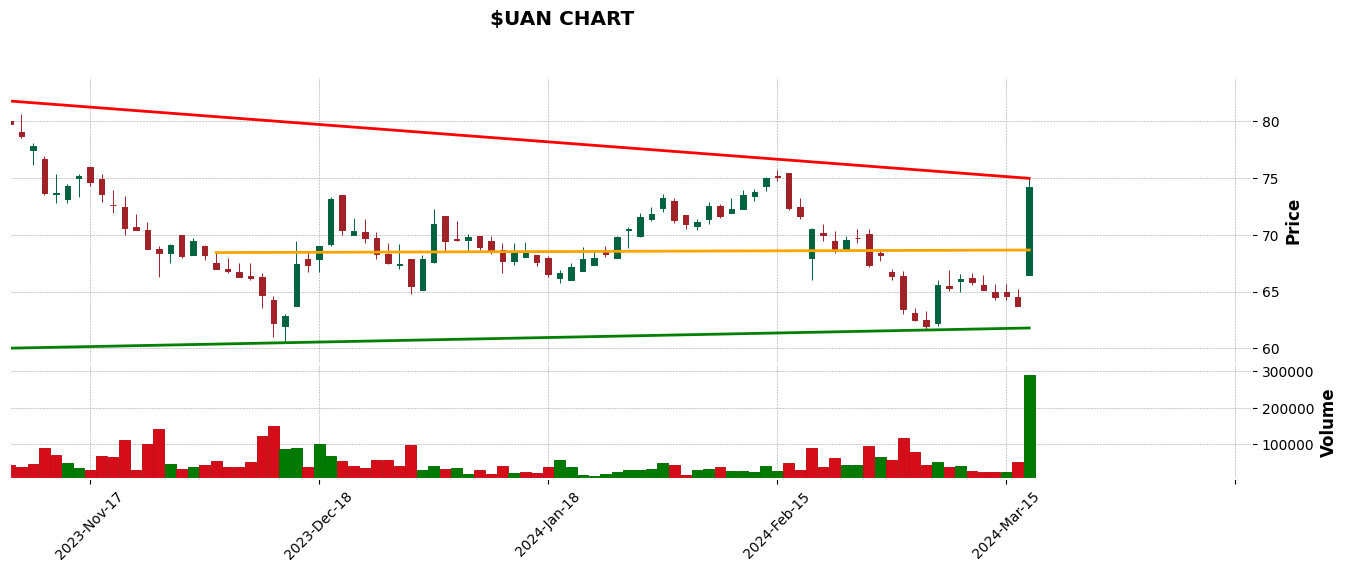

In [118]:
#### CHART IT ####
# Define the period for the x-axis view and future extension
lookback_periods = 90
future_periods = 20

# Calculate the extended index for the lookback period
lookback_index = ticker_df.index[-lookback_periods]

# Generate the future index by adding the future periods to the last date
future_index = pd.date_range(start=ticker_df.index[-1] + pd.Timedelta(days=1),
                             periods=future_periods, freq='B')

# Combine the current and future indices
full_index = ticker_df.index.union(future_index)

# Set the xlim for plotting
xlim = (lookback_index, full_index[-1])

# Plot the candlestick chart with extended x-axis
mpf.plot(ticker_df,
         type='candle',
         style='charles',
         volume=True,
         title=f'${ticker} CHART',
         figratio=(42, 14),
         xlim=xlim,  # Set the new x-axis limits
         addplot=apds)  # 'apds' should contain all your additional plots

In [ ]:
ticker_df.tail(10)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-03-06,UAN,61.98,63.2737,61.6200,62.50,44400
2024-03-07,UAN,65.63,66.0300,62.0100,62.22,52702
2024-03-08,UAN,65.32,66.8700,65.0315,65.50,38369
2024-03-11,UAN,66.09,66.5750,65.0000,65.92,40912
2024-03-12,UAN,65.86,66.6800,65.5901,66.21,25801
2024-03-13,UAN,65.13,66.4700,65.1300,65.58,22702
2024-03-14,UAN,64.52,65.6800,64.2400,64.97,23567
2024-03-15,UAN,64.58,65.6700,64.2501,64.96,25339
2024-03-18,UAN,63.72,65.2000,63.7100,64.50,50996


In [ ]:
support_line

array([59.76055885, 59.78054375, 59.80052864, 59.82051354, 59.84049843,
       59.86048333, 59.88046823, 59.90045312, 59.92043802, 59.94042291,
       59.96040781, 59.98039271, 60.0003776 , 60.0203625 , 60.04034739,
       60.06033229, 60.08031719, 60.10030208, 60.12028698, 60.14027187,
       60.16025677, 60.18024166, 60.20022656, 60.22021146, 60.24019635,
       60.26018125, 60.28016614, 60.30015104, 60.32013594, 60.34012083,
       60.36010573, 60.38009062, 60.40007552, 60.42006042, 60.44004531,
       60.46003021, 60.4800151 , 60.5       , 60.5199849 , 60.53996979,
       60.55995469, 60.57993958, 60.59992448, 60.61990938, 60.63989427,
       60.65987917, 60.67986406, 60.69984896, 60.71983386, 60.73981875,
       60.75980365, 60.77978854, 60.79977344, 60.81975834, 60.83974323,
       60.85972813, 60.87971302, 60.89969792, 60.91968281, 60.93966771,
       60.95965261, 60.9796375 , 60.9996224 , 61.01960729, 61.03959219,
       61.05957709, 61.07956198, 61.09954688, 61.11953177, 61.13

# END ADVANCED WIP TESTS

| DATA PACKAGE |
|-|
| Trend Lines |


In [ ]:
# # Step 3: Calculate the y-values for the line of best fit for the last 72 periods
# best_fit_last_72 = model.predict(X)

# # Create a series for the best fit line, filled with NaN except for the last 72 values
# best_fit_series = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# # best_fit_series = pd.Series(model.predict(X), index=last_72_df.index)
# best_fit_series[-72:] = best_fit_last_72

# # # Step 4: Pivot Points
# # pivot_point_low_index = last_72_df['Close'].idxmin()
# # pivot_point_low_value = last_72_df.loc[pivot_point_low_index, 'Close']

# # pivot_point_high_index = last_72_df['Close'].idxmax()
# # pivot_point_high_value = last_72_df.loc[pivot_point_high_index, 'Close']

# # # Create a series for the pivot points, similar to the best fit line
# # pivot_points_low = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# # pivot_points_low[pivot_point_low_index] = pivot_point_low_value

# # pivot_points_high = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# # pivot_points_high[pivot_point_high_index] = pivot_point_high_value

# # # Step X: chart it
# # last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

# # mpf.plot(ticker_df,
# #          type='candle',
# #          style='charles',
# #          volume=True,
# #          title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
# #          figratio=(42, 14),
# #          xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
# #          addplot=apds)

# # mpf.show()


# # # step 5: chart setup
# # apds = [
# #     mpf.make_addplot(best_fit_series, color='orange', width=2),
# #     mpf.make_addplot(pivot_points_low, type='scatter', markersize=200, marker='x', color='red'),
# #     mpf.make_addplot(pivot_points_high, type='scatter', markersize=200, marker='x', color='green')  # Green X for the highest point
# # ]

# # # Step X: chart it
# # last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

# # mpf.plot(ticker_df,
# #          type='candle',
# #          style='charles',
# #          volume=True,
# #          title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
# #          figratio=(42, 14),
# #          xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
# #          addplot=apds)

# # mpf.show()

In [ ]:
# # step 5: chart setup
# apds = [
#     mpf.make_addplot(best_fit_series, color='orange', width=2),
#     mpf.make_addplot(pivot_points_low, type='scatter', markersize=200, marker='x', color='red'),
#     mpf.make_addplot(pivot_points_high, type='scatter', markersize=200, marker='x', color='green')  # Green X for the highest point
# ]

In [ ]:
# # Step X: chart it
# last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

# mpf.plot(ticker_df,
#          type='candle',
#          style='charles',
#          volume=True,
#          title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
#          figratio=(42, 14),
#          xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
#          addplot=apds)

# mpf.show()


50DSMA - needed bc everyone has it
standard deviations (2 above)
63DMA - makes at least more sense (63 trading days in a quarter)
2dVWAP
3dVWAP
AVWAP

| Dataframe -> .csv file |
|-|

In [ ]:
# # create a csv file with a flat date index (otherwise it'll get lost when saving to csv)
# ticker_csv_df = ticker_df.reset_index()
# # dtype of date
# print(ticker_csv_df['date'].dtype)
# # print index type
# print(ticker_csv_df.index.dtype)

# # save to csv
# ticker_csv_df.to_csv(f'{ticker}_historical_data{today_date_str}', index=False)

# ticker_csv_df.head(2)


In [ ]:
# #### add VWAP to df
# chart_historical_df['VWAP'] = (chart_historical_df['volume'] * (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3).cumsum() / chart_historical_df['volume'].cumsum()

# chart_historical_df.head(4)

In [ ]:
# """SIMPLE MOVING AVERAGES (SMA)"""
# def calculate_sma(dataframe, period):
#     return dataframe['close'].rolling(window=period).mean()

# chart_historical_df['SMA5'] = calculate_sma(chart_historical_df, 5)
# chart_historical_df['SMA10'] = calculate_sma(chart_historical_df, 10)
# chart_historical_df['SMA15'] = calculate_sma(chart_historical_df, 15)

# chart_historical_df.tail(10)


In [ ]:
# """EXPONENTIAL MOVING AVERAGES (EMA)"""
# def calculate_ema(dataframe, period):
#     return dataframe['close'].ewm(span=period, adjust=False).mean()

# # calculate EMAs for the specified periods
# chart_historical_df['EMA5'] = calculate_ema(chart_historical_df, 5)
# chart_historical_df['EMA10'] = calculate_ema(chart_historical_df, 10)
# chart_historical_df['EMA20'] = calculate_ema(chart_historical_df, 20)
# chart_historical_df['EMA50'] = calculate_ema(chart_historical_df, 50)

# chart_historical_df.tail(10)


In [ ]:
# """MOVING AVERAGE CONVERGENCE DIVERGENCE (MACD)"""
# # calculate the MACD line and the Signal line
# chart_historical_df['MACD'] = calculate_ema(chart_historical_df, 12) - calculate_ema(chart_historical_df, 26)
# chart_historical_df['MACD_Signal'] = chart_historical_df['MACD'].ewm(span=9, adjust=False).mean()

# # MACD Histogram -> useful for visualizing momentum and potential buy/sell signals
# chart_historical_df['MACD_Histogram'] = chart_historical_df['MACD'] - chart_historical_df['MACD_Signal']

# chart_historical_df.tail(10)

In [ ]:
# #### DEV - DATA ORGANIZATION ####
# chart_historical_df.columns

In [ ]:
# """BOLLINGER BANDS (BB)"""
# # BB 1 of 2 -> standard bollinger bands (20D CLOSE $)
# period = 20 # SMA periods
# std_dev_multiplier = 2 # standard deviation multiplier

# # line 1: middle band -> simple moving average (SMA)
# chart_historical_df[f'middle_band_SMA{period}'] = chart_historical_df['close'].rolling(window=period).mean()

# # not a line: standard deviation -> used to calculate the upper and lower bands
# chart_historical_df[f'std_dev_SMA{period}'] = chart_historical_df['close'].rolling(window=period).std()

# # lines 2 & 3: upper and lower bands
# chart_historical_df[f'upper_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] + (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] - (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)


# # BB 2 of 2 -> typical price bollinger bands (20D TYPICAL $)
# chart_historical_df['typical_price'] = (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3

# # Calculate the SMA of the Typical Price and name it 'middle_band_typical_SMA20'
# chart_historical_df[f'middle_band_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).mean()

# # Calculate the standard deviation of the Typical Price
# chart_historical_df[f'std_dev_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).std()

# # Calculate the upper and lower bands for the Typical Price and name them accordingly
# chart_historical_df[f'upper_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] + (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] - (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)

# # view df with new (2) BBs (6 new columns)
# # chart_historical_df.iloc[-1] # last row slice to check the new columns
# chart_historical_df.tail(2)


In [ ]:
# chart_historical_df.head(5)

In [ ]:
# # drop rows that contain NAs (pulled extra data earlier for this purpose)
# chart_historical_df = chart_historical_df.dropna()

# # view the df
# chart_historical_df.head(5)

In [ ]:
# # date column check data type
# chart_historical_df.index

In [ ]:
# # IMPORTANT: reset index before saving to Excel (need this shit flat so we don't lose the 'date' index)
# chart_historical_df.reset_index(inplace=True)

In [ ]:
# chart_historical_df.index

In [ ]:
# chart_historical_df.head(5)

In [ ]:
# print(tv_L2_df.columns)

In [ ]:
# # takes the original DataFrame and a list of stock symbols,
# # returns a dictionary of DataFrames, one for each stock symbol
# def create_symbol_dataframes(df, symbols):
#     symbol_dfs = {}
#     for symbol in symbols:
#         # Filter the DataFrame for the symbol and store it in a dictionary
#         symbol_dfs[f"{symbol}_chart_df"] = df[df['symbol'] == symbol]
    
#     return symbol_dfs


# symbols = mvp_chart_df['symbol'].unique() 
# symbol_dataframes = create_symbol_dataframes(mvp_chart_df, symbols)

# mtn_df = symbol_dataframes['MTN_chart_df']

# print(symbol_dataframes)



| CALCULATIONS - J. Welles Wilder Jr (technical indicators) |
|-|
| *displayed underneath the chart not overlayed* |
| START |

In [ ]:
# """RELATIVE STRENGTH INDEX (RSI)"""
# def calculate_rsi(dataframe, periods=14):
#     close_delta = dataframe['close'].diff()
#     up = close_delta.clip(lower=0)
#     down = -1 * close_delta.clip(upper=0)

#     ma_up = up.rolling(window=periods).mean()
#     ma_down = down.rolling(window=periods).mean()

#     rsi = ma_up / (ma_up + ma_down) * 100
#     return rsi

# # Adding the RSI to your DataFrame
# chart_historical_df['RSI'] = calculate_rsi(chart_historical_df)

# chart_historical_df.tail(10)


In [ ]:
# """AVERAGE TRUE RANGE (ATR)"""
# def calculate_atr(dataframe, period=14):
#     high_low = dataframe['high'] - dataframe['low']
#     high_close = (dataframe['high'] - dataframe['close'].shift()).abs()
#     low_close = (dataframe['low'] - dataframe['close'].shift()).abs()

#     # Calculate the True Range (TR) as the maximum of the three measures
#     tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

#     # Calculate the ATR by taking the rolling mean of the TR
#     atr = tr.rolling(window=period).mean()
    
#     return atr

# # Adding the ATR to your DataFrame
# chart_historical_df['ATR'] = calculate_atr(chart_historical_df)

# chart_historical_df.tail(10)

In [ ]:
# START HERE
# see about if i should be doing a multi-index and group by if it makes the code more efficient and accurate and all that
# simple data plot soon to see what we are working with and if there are bugs

In [ ]:
"""Average Directional Index (ADX)"""

'Average Directional Index (ADX)'

In [ ]:
"""PARABOLIC SAR (PSAR)"""

'PARABOLIC SAR (PSAR)'

| J. Welles Wilder Jr (technical indicators) |
|-|
| END |

In [ ]:
# LINE LEVELS not full calculation dataframe
# part 1 was calculations append
# part 2 is data points append
# part 3 extra - could be plotting past signals (might integrate ai in here like tensorflow)

| CHARTS |
|-|

In [ ]:
# #### xlwings -> dynamic send to excel ####
# # save name for todays returend gap up stocks historical data
# chart_data_file = f'chart_data{today_date_str}.xlsx'

# # reset index before saving to Excel (need
# chart_historical_df.reset_index(inplace=True, drop=True)

# # Save the DataFrame to an Excel file
# chart_historical_df.to_excel(chart_data_file, index=False)

# # Use xlwings to open the file in Excel
# app = xw.App(visible=True)
# book = app.books.open(chart_data_file)

In [ ]:
# # AVAILABLE COLS
# chart_historical_df.columns

In [ ]:
# def plot_symbol_technicals(chart_historical_df, symbol):
#     # FILTER
#     symbol_df = chart_historical_df[chart_historical_df['symbol'] == symbol].copy()
    
#     # print(symbol_df.head(5))
#     # DATA PREP
#     add2plot = [
#         # mpf.make_addplot(symbol_df['SMA5'], color='#7BAFD4', width=1.0, label='SMA5'), 
#         # mpf.make_addplot(symbol_df['SMA10'], color='#003087', width=1.0, label='SMA10'), 
#         mpf.make_addplot(symbol_df['VWAP'], color='#B31B1B', width=1.0, label='VWAP')
#     ]
    
#     # STYLE & PLOT
#     mpf_style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={'text.color': 'white'})
#     fig, axes = mpf.plot(symbol_df,
#                          type='candle',
#                          addplot=add2plot,
#                          volume=True,
#                          style=mpf_style,
#                         #  style='yahoo',
#                          figratio=(42, 12),
#                          title=f'${symbol} - Historical Data (4 Months)',
#                          tight_layout=True,
#                          returnfig=True)

#     # watermark
#     fig.text(0.5, 0.5, symbol, fontsize=50, color='gray', alpha=0.5, ha='center', va='center', rotation=0, transform=fig.transFigure)

#     mpf.show()


In [ ]:
# # print a list of the unique stock symbols
# unique_symbols = chart_historical_df['symbol'].unique()
# print(f'Unique stock symbols: {unique_symbols}')

In [ ]:
# #### EXECUTE CHARTING ####
# # DEV
# plot_symbol_technicals(chart_historical_df, 'GRND')

# # # PRO
# # for unique in unique_symbols:
# #     plot_symbol_technicals(chart_historical_df, unique)

| END OF IN PROGRESS WORK - NOTES BELOW |
|--|

In [ ]:
""" 
ISSUE: some weird shit with the style param
nbd tho ctfo. 

workaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  
the blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style
experienced similar shit like this years ago, idunno will get to it.

"""

' \nISSUE: some weird shit with the style param\nnbd tho ctfo. \n\nworkaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  \nthe blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style\nexperienced similar shit like this years ago, idunno will get to it.\n\n'

In [ ]:
# you're going to need different charts, one for the pre-market, and at least another for market open
# I'd like market opens to be a live feed but really we might already be in trading view watching the pine script execute

# Trend lines

In [ ]:
# but first start with getting lines on that chart with STRV
# let's get those key levels with an output on them and figure out your strategy
# figure out when fibonacci extensions get activated
# i see one view with a grid layout of the stock charts above or below them the summary with the key levels, current price and all that
# i also see a view where when looking at individiual stocks we got data all over that shit. idgaf if it's "confusing for the user"

# you have your key_levels_df
# so start next from there okay

#### </b> ####

# make title more symetrically bigger not just bigger for fucks sake 
# move price to the right side, keep vol on left
# see if you can get a marker or military like custom google font one of the ones you like
# better yet use that program you wrote for sn logos actually to create your shit
# could put that Sans Peur Systems somewhere at least watermark it, maybe?
# key levels find up to 6?, scoring strategy?, then base allotment of position (1/3, 1/5) conditionally?
# we could add RSI down there, fuck could add ichimoku, do whatever with all this data access now

NOTES -> SMA Legend

In [ ]:
# # SMA20, SMA50, and SMA200 has to be in 'dell_df'
# legend_info = {
#     'Indicator': ['SMA20', 'SMA50', 'SMA200'],
#     'Color': ['blue', 'orange', 'green'],
#     'Description': ['20-day Moving Average', '50-day Moving Average', '200-day Moving Average']
# }

# legend_df = pd.DataFrame(legend_info)
# print(legend_df)


NOTES -> custom mplfinance chart setup example

In [ ]:
# """    
# Custom Theme setup
# """

# dark_style = mpf.make_mpf_style(base_mpf_style='charles', 
#                                 rc={'axes.facecolor': 'black',
#                                     'figure.facecolor': 'darkslategrey',
#                                     'axes.grid': True,
#                                     'grid.color': 'gray',
#                                     'grid.linestyle': '--',
#                                     'grid.linewidth': 0.6,
#                                     'axes.titlesize': 16,
#                                     'axes.titleweight': 'bold',
#                                     'axes.labelsize': 12,
#                                     'axes.labelweight': 'bold',
#                                     'axes.labelcolor': 'white',
#                                     'axes.edgecolor': 'white',
#                                     'axes.linewidth': 2,
#                                     'xtick.color': 'white',
#                                     'xtick.labelsize': 10,
#                                     'ytick.color': 'white',
#                                     'ytick.labelsize': 10,
#                                     'figure.titlesize': 18,
#                                     'figure.titleweight': 'bold',
#                                     'legend.facecolor': 'grey',
#                                     'legend.edgecolor': 'white',
#                                     'legend.fontsize': 10,
#                                     'legend.title_fontsize': 12})

# mpf.plot(strv_df, 
#          type='candle', 
#          style=dark_style,  # Using the custom dark style
#          volume=True, 
#          title='STRV Candlestick Chart',
#          mav=(20, 50, 200),  # Adding moving averages of 20, 50, and 200 periods
#          figratio=(15, 8), 
#          tight_layout=True)

In [ ]:
# i need a math checker for trading days vs calendar days (252/365)

Notes -> yahoo finance API exaple (free) *with limitations

In [ ]:
# import yfinance as yf
# from datetime import datetime, timedelta

In [ ]:
# # yahoo finance data download
# start = datetime.now() - timedelta(days=60)
# end = datetime.now()
# yahoo_df = yf.download(gap_up_stocks_list, start, end)
# yahoo_df = yahoo_df.loc[:,'Close']
# # view the yahoo data yahoo finance formatting multi-index (has a 60day max with standard API maneuvers)
# yahoo_df.head(10)